# Starbucks Capstone Data Analysis

* This data set contains simulated data that mimics customer behavior on the Starbuck rewards mobile app. Original data were provided by Starbucks through Udacity Data Scientist Nanodegree Program.

* We will follow CRISP-DM (Cross-Industry Standard Process for Data Mining) process
    * Business Understanding
    * Data Understanding
    * Data Preparation
    * Modelling
    * Evaluation
    * Deployment

## Business Understanding

As part of the Udacity Data Scientists Nanodegree Captone project, Starbucks has kindly provided simulated promotional datasets that mimic customer behavior on the rewards mobile app. The promotion runs like the following: once every few days, Starbucks will send out promotions to customers. The promotions could be discount offers, buy-one-get-one-free (bogo) offers, or informational offers. Different customers might react differently to the offers. Some customers will react positively to the promotions (viewed the offer and placed an order), whereas other customer might ignore the promotions (did not place an order after viewing the promotions, or placed an order without noticing the promotions). Since there is a cost associated with the promotion, analysis of the data could be helpful for understanding customer behaviors, making business decision, and implementing strategies to improve the business profits.

In this analysis, we are interested in the following questions:

1. What are the demographic data of the customers?
2. How various genders respond to the promotions differently?
3. What is the best channel to send out promotions?
4. Of all the different promotional offers, which one is more profitable for Starbucks?
5. Can we build a model to predict the customers' behavior and send out customized promotional offers to individuals?


## Data Understanding

There are three files in `./data` folder.

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [7]:
# Import relevant modules
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### portfolio data

In [4]:
print(portfolio.shape)
display(portfolio)

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.isnull().mean()

reward        0.0
channels      0.0
difficulty    0.0
duration      0.0
offer_type    0.0
id            0.0
dtype: float64

### portfolio data summary 

There are 10 different promotional offers with distint ids. Each offer has its own difficulty, reward, and durations. The offers are delivered via multiple channels including web, email, mobile, and social. These offers are grouped into three types: bogo, informational, and discount.

To preprocess/clean the portfolio dataset, it is useful to do one-hot encoding of the channel and offer_type columns.

In [5]:
def clean_portfolio(portfolio):
    """
    Cleaning portfolio dataframe: one hot encoding of the channels and offer_type. 
    drop original channels columns. Keep original offer_type column
    
    Input: raw portfolio dataframe
    Output: cleaned portfolio dataframe
    """
    cleaned_data = portfolio.copy()

    # one hot encoding for channel column
    for channel in ['web', 'email', 'mobile', 'social']:
        cleaned_data[channel] = cleaned_data['channels'].apply(lambda x: 1 if channel in x else 0)

    # one hot encoding for offer_type column
    offer_type = pd.get_dummies(cleaned_data['offer_type'])
    cleaned_data = pd.concat([cleaned_data, offer_type], axis=1)
    # Keep original offer_type for exploratory analysis, only drop channels
    cleaned_data.drop(['channels'], axis=1, inplace=True)

    return cleaned_data

In [6]:
# Quickly examine the cleaned portfolio dataset
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


### profile data

In [8]:
print(profile.shape)
display(profile)

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [14]:
print(profile.isnull().mean())
print("Percentage of age 118={:.6f}".format(profile[profile.age == 118].shape[0] / profile.shape[0]))

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64
Percentage of age 118=0.127941


In [15]:
## From the above analysis, it is reasonable to assume that age=118 
## is for customers who do not have gender or income information
## Further analysis proves the assumption

In [16]:
def clean_profile(profile):
    """
    Cleaning profile dataframe:
        remove customer who do not have gender or income data; one-hot encoding gender; feature engineering member date
    Input: profile dataframe to be cleaned
    Output: cleaned profile dataframe
    """
    cleaned_data = profile.copy()
    cleaned_data.loc[cleaned_data.age == 118, 'age'] = np.nan
    cleaned_data.dropna(inplace=True)
    cleaned_data['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(cleaned_data['became_member_on'], 
                                                                              format='%Y%m%d').dt.date
    cleaned_data['memberdays'] = cleaned_data['memberdays'].dt.days
    cleaned_data['year_join'] = pd.to_datetime(cleaned_data['became_member_on'], format='%Y%m%d').dt.year
    # one hot encoding for event column
    gender_df = pd.get_dummies(cleaned_data['gender'])
    cleaned_data = pd.concat([cleaned_data, gender_df], axis=1)
    return cleaned_data

In [17]:
cleaned_profile = clean_profile(profile)
cleaned_profile.head()

,gender,age,id,became_member_on,income,memberdays,year_join,F,M,O
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1742,2017,1,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1809,2017,1,0,0
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0,1457,2018,0,1,0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,1533,2018,0,1,0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1623,2017,0,1,0


In [18]:
cleaned_profile.describe()

,age,became_member_on,income,memberdays,year_join,F,M,O
count,14825.000000,1.482500e+04,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,2.016689e+07,65404.991568,1888.478988,2016.620169,0.413423,0.572277,0.014300
std,17.383705,1.188565e+04,21598.299410,419.205158,1.198245,0.492464,0.494765,0.118729
min,18.000000,2.013073e+07,30000.000000,1366.000000,2013.000000,0.000000,0.000000,0.000000
25%,42.000000,2.016052e+07,49000.000000,1574.000000,2016.000000,0.000000,0.000000,0.000000
50%,55.000000,2.017080e+07,64000.000000,1724.000000,2017.000000,0.000000,1.000000,0.000000
75%,66.000000,2.017123e+07,80000.000000,2163.000000,2017.000000,1.000000,1.000000,0.000000
max,101.000000,2.018073e+07,120000.000000,3189.000000,2018.000000,1.000000,1.000000,1.000000


### What are the demographic data of the customers?

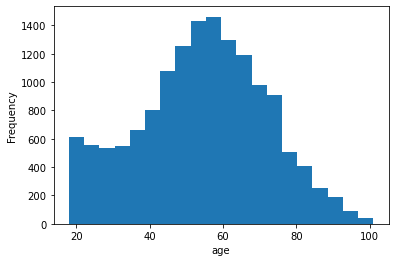

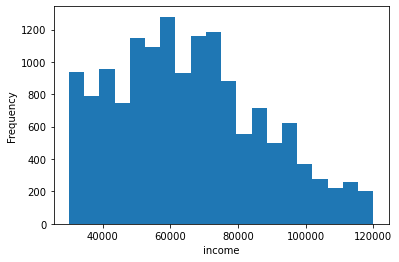

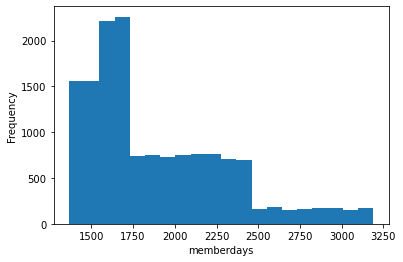

In [15]:
for label in ['age', 'income', 'memberdays']:
    plt.figure()
    fig = cleaned_profile[label].plot(kind='hist', bins=20)
    fig.set_xlabel(label)

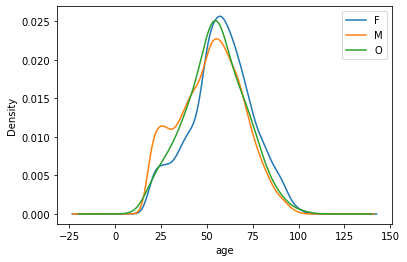

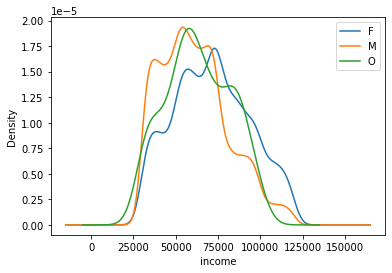

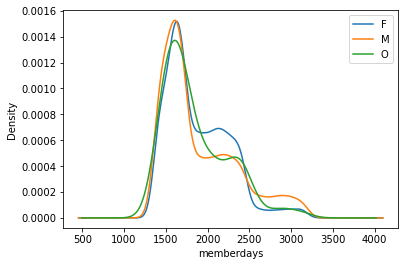

In [23]:
for label in ['age', 'income', 'memberdays']:
    plt.figure()
    cleaned_profile.groupby('gender')[label].plot.density()
    plt.legend()
    plt.xlabel(label)
    plt.show()

### Transcript data

In [24]:
print(transcript.shape)
display(transcript)

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [25]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [31]:
# View data from one specific customer
transcript[transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


### Quick Summary of the transcript data
* offer flow: offer received --> offer viewed --> transaction --> offer completed
* Some offers might not be used: offer received --> offer viewed --> STOP
* Some offers only contain transaction (no direct corresponding offer completed)

In [32]:
transcript.isnull().mean()

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

In [33]:
# Quick summarize the transcript event data
display(pd.DataFrame(transcript.event.value_counts()).T \
        .assign(missing=transcript.event.isna().sum()) \
        .assign(total=transcript.count()) \
        .style.set_caption('Count events'))

,transaction,offer received,offer viewed,offer completed,missing,total
event,138953,76277,57725,33579,0,306534


In [34]:
def clean_transcript(transcript):
    """
    Clean transcript data: unpack value column, one hot encoding transaction event
    Input: raw transcript data
    Output: break values column to multiple columns, 
    """
    transcript_df = transcript.copy()
    
    # note: from_records need sequence index from 0
    transcript_df = transcript_df.join(pd.DataFrame.from_records(transcript_df.pop('value')))
    transcript_df.offer_id.update(transcript_df.pop('offer id')) # update non NaN values only
    
    # one hot encoding for event column
    event_df = pd.get_dummies(transcript_df['event'])
    transcript_df = pd.concat([transcript_df, event_df], axis=1)
   
    return transcript_df

In [35]:
cleaned_transcript = clean_transcript(transcript)
cleaned_transcript.head()

,person,event,time,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0


In [36]:
# Count different events
pd.DataFrame(cleaned_transcript.event.value_counts()).T

,transaction,offer received,offer viewed,offer completed
event,138953,76277,57725,33579


### Count event types under different conditions
Note: as different groups receive different number of offers, a better representation is the completed/received ratio. 

In [37]:
offer_event = cleaned_portfolio.set_index('id')
offer_event = offer_event.assign(
    received=pd.DataFrame(
        cleaned_transcript.query('event == "offer received"')
        .offer_id.value_counts()))
offer_event = offer_event.assign(
    viewed=pd.DataFrame(
        cleaned_transcript.query('event == "offer viewed"')
        .offer_id.value_counts()))
offer_event = offer_event.assign(
    completed=pd.DataFrame(
        cleaned_transcript.query('event == "offer completed"')
        .offer_id.value_counts()))
display(offer_event)

,reward,difficulty,duration,offer_type,web,email,mobile,social,bogo,discount,informational,received,viewed,completed
id,,,,,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,0,1,1,1,1,0,0,7658,6716,3688.0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1,1,1,1,1,0,0,7593,7298,3331.0
3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,1,0,0,0,1,7617,4144,NaN
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,1,0,1,0,0,7677,4171,4354.0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,1,1,0,0,0,1,0,7668,2663,3420.0
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,1,1,1,1,0,1,0,7646,7337,5156.0
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,1,1,1,1,0,1,0,7597,7327,5317.0
5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,0,1,1,1,0,0,1,7618,6687,NaN
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1,1,1,1,1,0,0,7571,7264,4296.0


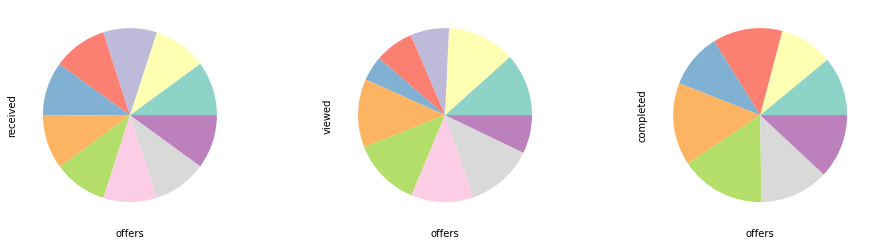

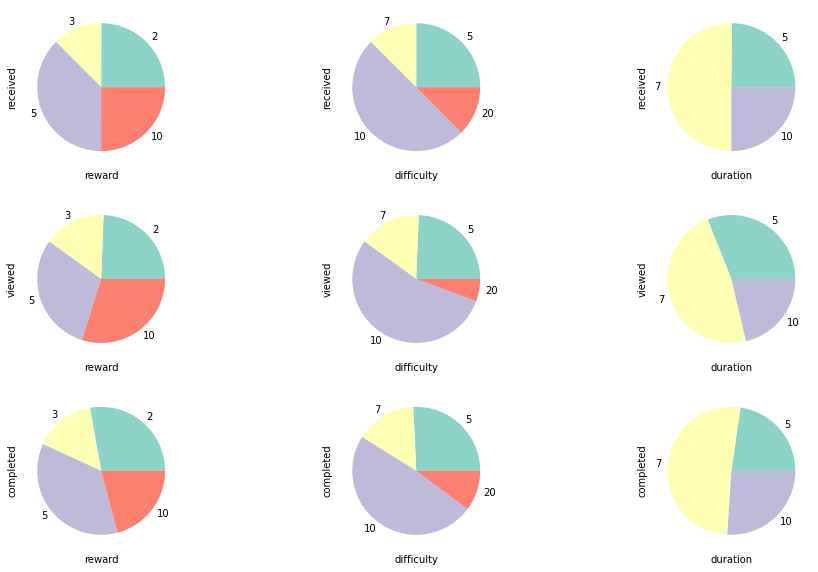

In [38]:
cmap = plt.get_cmap("Set3")
colors = cmap(range(10))
# Plot
fig, axs = plt.subplots(figsize=(16,4), nrows=1, ncols=3)
offer_event.received.plot.pie(ax=axs[0], labels=None, colors=colors)
offer_event.viewed.plot.pie(ax=axs[1], labels=None, colors=colors)
offer_event.completed.plot.pie(ax=axs[2], labels=None, colors=colors)
axs[0].set_xlabel('offers')
axs[1].set_xlabel('offers')
axs[2].set_xlabel('offers')
plt.show()

## Group events by reward, difficulty, and duration
fig, axs = plt.subplots(figsize=(16,10), nrows=3, ncols=3)

offer_event = offer_event.query('informational == 0')
event_by_reward = offer_event.groupby('reward').sum()
event_by_reward.received.plot.pie(ax=axs[0][0], colors=colors)
event_by_reward.viewed.plot.pie(ax=axs[1][0], colors=colors)
event_by_reward.completed.plot.pie(ax=axs[2][0], colors=colors)
axs[0][0].set_xlabel('reward')
axs[1][0].set_xlabel('reward')
axs[2][0].set_xlabel('reward')

event_by_difficulty = offer_event.groupby('difficulty').sum()
event_by_difficulty.received.plot.pie(ax=axs[0][1], colors=colors)
event_by_difficulty.viewed.plot.pie(ax=axs[1][1], colors=colors)
event_by_difficulty.completed.plot.pie(ax=axs[2][1], colors=colors)
axs[0][1].set_xlabel('difficulty')
axs[1][1].set_xlabel('difficulty')
axs[2][1].set_xlabel('difficulty')

event_by_duration = offer_event.groupby('duration').sum()
event_by_duration.received.plot.pie(ax=axs[0][2], colors=colors)
event_by_duration.viewed.plot.pie(ax=axs[1][2], colors=colors)
event_by_duration.completed.plot.pie(ax=axs[2][2], colors=colors)
axs[0][2].set_xlabel('duration')
axs[1][2].set_xlabel('duration')
axs[2][2].set_xlabel('duration')
plt.show()

In [39]:
cleaned_transcript.isnull().mean()

person             0.000000
event              0.000000
time               0.000000
amount             0.546696
offer_id           0.453304
reward             0.890456
offer completed    0.000000
offer received     0.000000
offer viewed       0.000000
transaction        0.000000
dtype: float64

In [40]:
transcript[transcript.event != 'transaction'].shape

(167581, 4)

### Aggregate Data set

In [42]:

all_data = cleaned_transcript.merge(cleaned_portfolio.rename(columns={"reward": "reward_p"}),
                                    left_on="offer_id", right_on="id")
all_data.drop(columns=['id'], inplace=True)
all_data.shape

(167581, 21)

In [43]:
all_data = all_data.merge(cleaned_profile, left_on="person", right_on="id")
all_data.shape

(148805, 31)

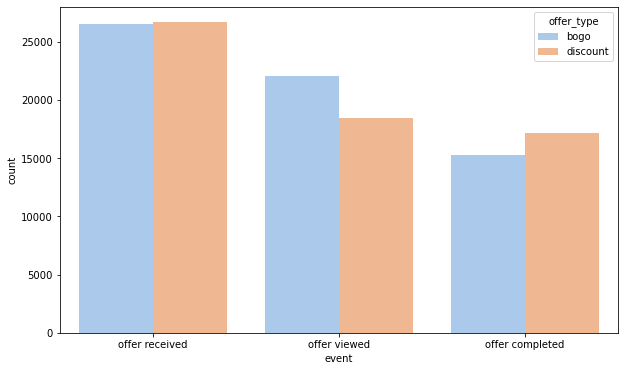

In [44]:
# Question: which offer is the most popular
data_non_info = all_data[all_data.informational == 0]
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=data_non_info, x='event', hue='offer_type', palette='pastel')
plt.show()

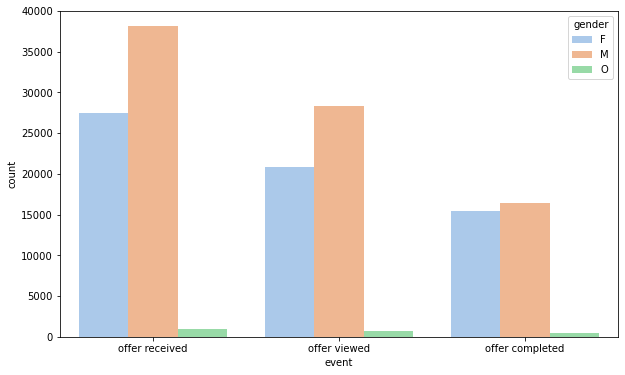

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=all_data, x='event', hue='gender', palette='pastel')
plt.show()

### Quick summary
* Almost equal amount of bogo and discount offers were sent out. More bogo offers were viewed, but more discount offer were completed
* A better metrics is to normalize the events, for example, (offer completed) / (offer received)

In [49]:
def agg_event(df, col="offer_type", items=None):
    """
    aggregate offer completion rate
    df: whole or subset of the merged dataset
    col: column of interest
    items: selected items in the column
    """
    if not items:
        items = df[col].unique()
    item = items[0]
    event = pd.DataFrame(df[df[col] == item]['event'].value_counts())
    event.rename(columns={'event': item}, inplace=True)
    for item in items[1:]:
        event[item] = pd.DataFrame(df[df[col] == item]['event'].value_counts())
    event_T = event.T
    event_T['completed/received'] = event_T['offer completed'] / event_T['offer received']
    event_T['viewed/received'] = event_T['offer viewed'] / event_T['offer received']
    event_T['completed/viewed'] = event_T['offer completed'] / event_T['offer viewed']
    
    return event_T.sort_index()

,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
bogo,26537,22039,15258,0.574971,0.830501,0.692318
discount,26664,18461,17186,0.644539,0.692357,0.930935


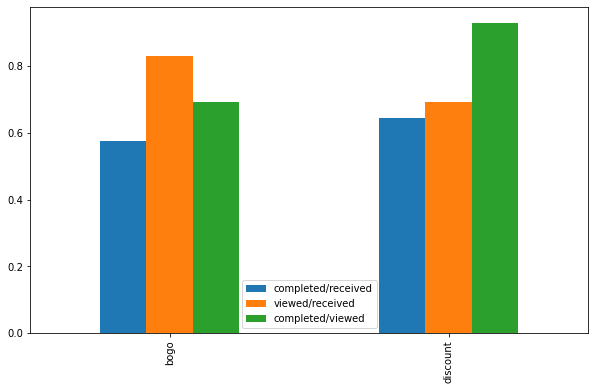

In [58]:
info = agg_event(all_data, col="offer_type", items=['bogo', 'discount'])
display(info)
info[['completed/received', 'viewed/received', 'completed/viewed']].plot(kind="bar", figsize=(10, 6))
plt.show()

,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,27456,20786,15477,0.563702,0.757066,0.744588
M,38129,28301,16466,0.431850,0.742243,0.581817
O,916,773,501,0.546943,0.843886,0.648124


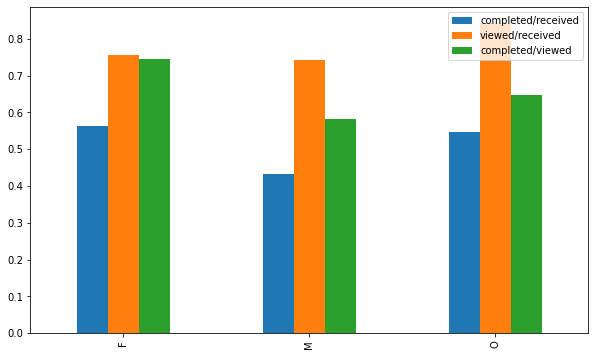

In [59]:
# Compare different offers with respect to gender
info = agg_event(all_data, col='gender')
display(info)
info[['completed/received', 'viewed/received', 'completed/viewed']].plot(kind="bar", figsize=(10, 6))
plt.show()

,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,10975,9143,7501,0.683462,0.833075,0.820409
M,15208,12581,7512,0.493951,0.827262,0.597091
O,354,315,245,0.692090,0.889831,0.777778


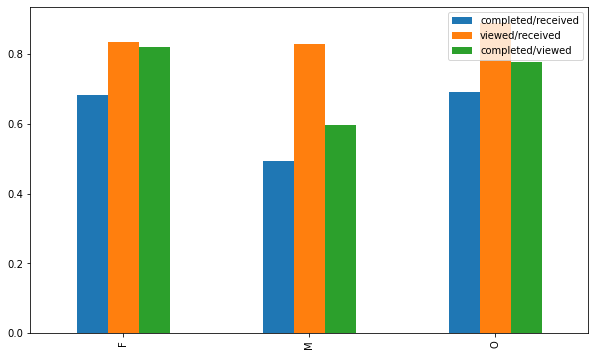

In [60]:
info = agg_event(all_data[all_data.bogo == 1], col='gender', items=['M', 'F', 'O'])
display(info)
info[['completed/received', 'viewed/received', 'completed/viewed']].plot(kind="bar", figsize=(10, 6))
plt.show()

,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,10943,7733,7976,0.728868,0.706662,1.031424
M,15354,10431,8954,0.583171,0.679367,0.858403
O,367,297,256,0.697548,0.809264,0.861953


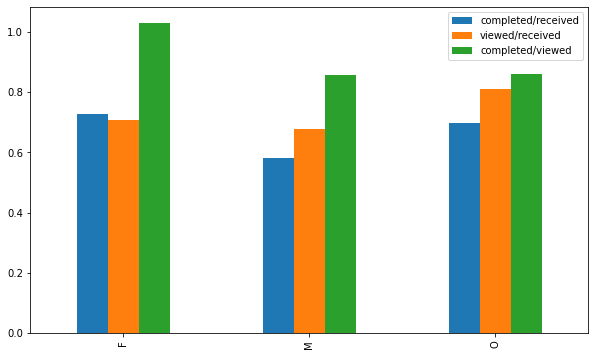

In [61]:
info = agg_event(all_data[all_data.discount == 1], col='gender', items=['M', 'F', 'O'])
display(info)
info[['completed/received', 'viewed/received', 'completed/viewed']].plot(kind="bar", figsize=(10, 6))
plt.show()

,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
2013,1226,913,561,0.457586,0.744698,0.614458
2014,2973,2259,1321,0.444332,0.759839,0.584772
2015,7150,5376,4319,0.604056,0.751888,0.803385
2016,13520,10319,8928,0.660355,0.763240,0.865200
2017,25125,18819,12119,0.482348,0.749015,0.643977
2018,16507,12174,5196,0.314776,0.737505,0.426811


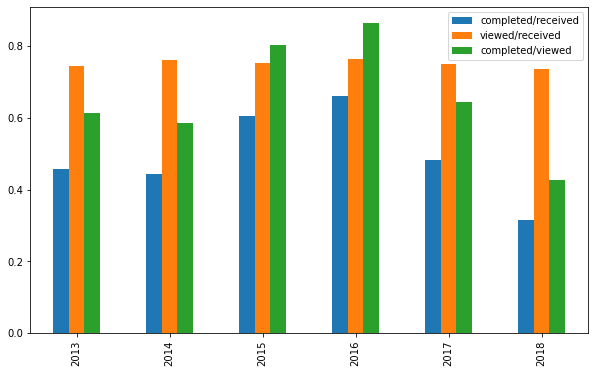

In [62]:
# Compare different offers with respect to gender
year = agg_event(all_data, col='year_join')
display(year)
year[['completed/received', 'viewed/received', 'completed/viewed']].plot(kind="bar", figsize=(10, 6))
plt.show()

In [57]:
### Check the scatter matrix of different offer types to age, income, gender, memberdays

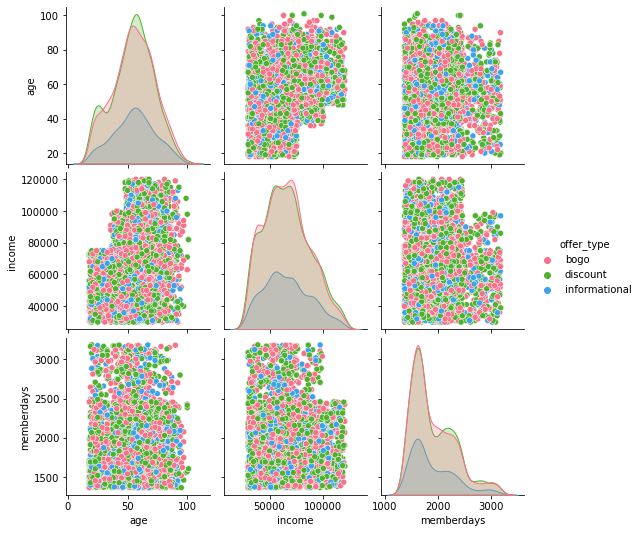

In [64]:
subset = all_data.sample(5000).copy()
offer_type = subset[['offer_type', 'age', 'income', 'gender', 'memberdays']]
sns.pairplot(offer_type, hue='offer_type', palette='husl')

### Questions 2, 3, 4: gender, channel, and type effect

,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,8225,6779,5644,0.686201,0.824195,0.832571
M,11368,9127,5771,0.507653,0.802868,0.632300
O,261,232,186,0.712644,0.888889,0.801724


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,10975,9143,7501,0.683462,0.833075,0.820409
M,15208,12581,7512,0.493951,0.827262,0.597091
O,354,315,245,0.692090,0.889831,0.777778


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,10975,9143,7501,0.683462,0.833075,0.820409
M,15208,12581,7512,0.493951,0.827262,0.597091
O,354,315,245,0.692090,0.889831,0.777778


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,8208,7599,5502,0.670322,0.925804,0.724043
M,11391,10702,5397,0.473795,0.939514,0.504298
O,253,239,171,0.675889,0.944664,0.715481


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,10943,7733,7976,0.728868,0.706662,1.031424
M,15354,10431,8954,0.583171,0.679367,0.858403
O,367,297,256,0.697548,0.809264,0.861953


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,10943,7733,7976,0.728868,0.706662,1.031424
M,15354,10431,8954,0.583171,0.679367,0.858403
O,367,297,256,0.697548,0.809264,0.861953


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,8142,6751,6273,0.770450,0.829157,0.929196
M,11528,9252,7334,0.636190,0.802568,0.792693
O,268,243,193,0.720149,0.906716,0.794239


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,5414,5222,4422,0.816771,0.964536,0.846802
M,7713,7386,5334,0.691560,0.957604,0.722177
O,180,178,133,0.738889,0.988889,0.747191


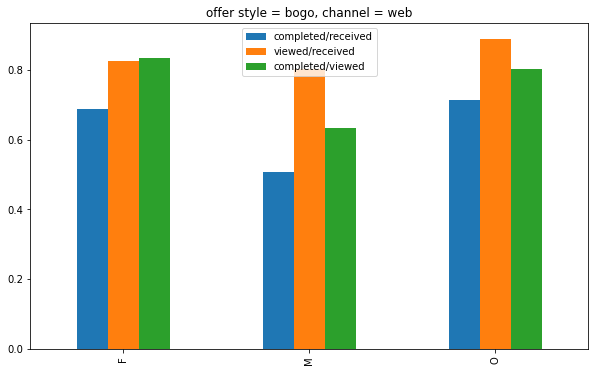

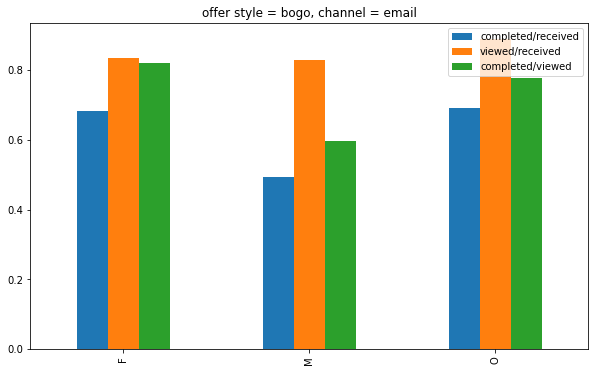

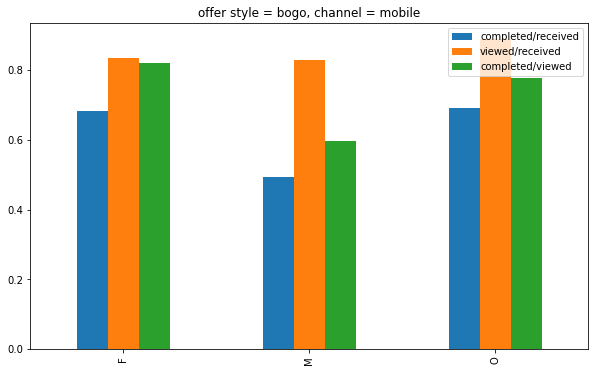

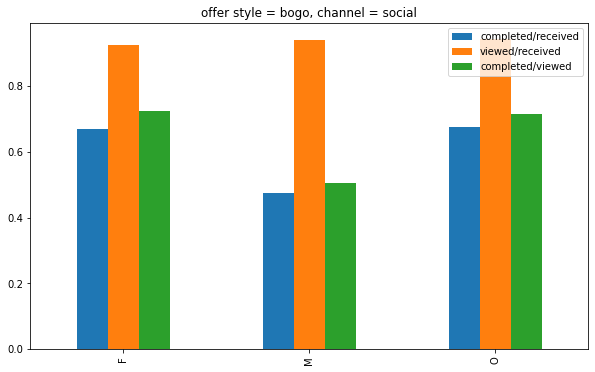

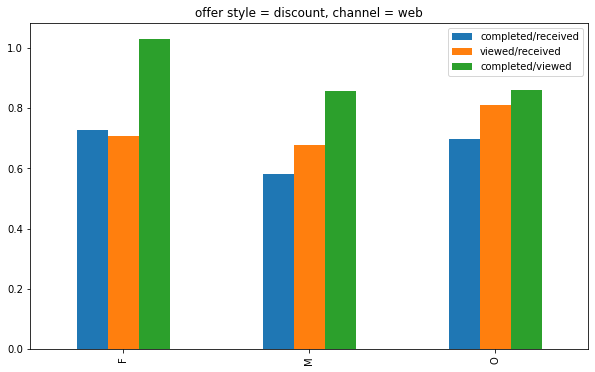

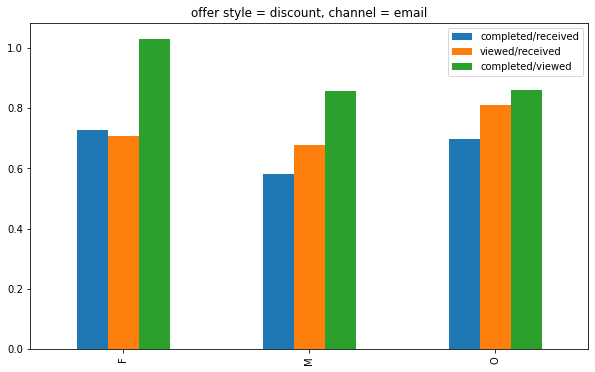

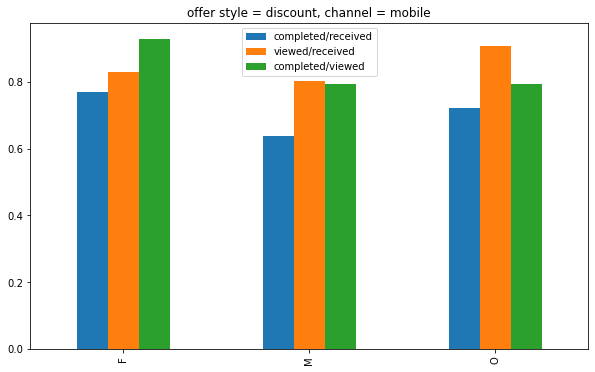

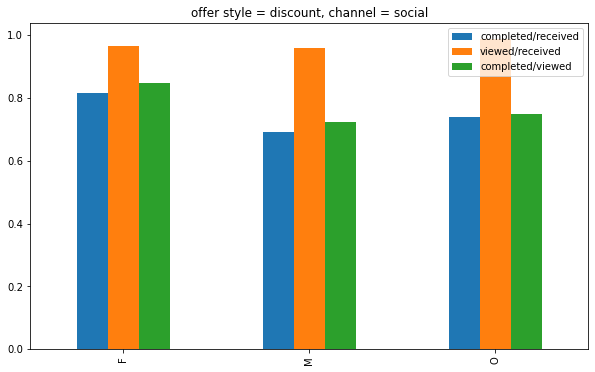

In [68]:
for offer_style in ['bogo', 'discount']:
    for channel in ['web', 'email', 'mobile', 'social']:
        agg = agg_event(all_data[(all_data[offer_style] == 1) & (all_data[channel] == 1)], col='gender', items=['M', 'F', 'O'])
        title = "offer style = {}, channel = {}".format(offer_style, channel)
        display(agg.style.set_caption(title))
        agg[['completed/received', 'viewed/received', 'completed/viewed']].plot(kind="bar", figsize=(10, 6))
        plt.title(title)
        

In [63]:
agg_event(all_data, col='offer_id')

,offer received,offer completed,offer viewed,completed/received,viewed/received,completed/viewed
0b1e1539f2cc45b7b9fa7c272da2e1d7,6726.0,3386.0,2215.0,0.503420,0.329319,1.528668
2298d6c36e964ae4a3e7e9706d1fb8c2,6655.0,4886.0,6379.0,0.734185,0.958527,0.765951
2906b810c7d4411798c6938adc9daaa5,6631.0,3911.0,3460.0,0.589805,0.521792,1.130347
3f207df678b143eea3cee63160fa8bed,6657.0,NaN,3487.0,NaN,0.523810,NaN
4d5c57ea9a6940dd891ad53e9dbe8da0,6593.0,3310.0,6329.0,0.502048,0.959958,0.522989
5a8bc65990b245e5a138643cd4eb9837,6643.0,NaN,5873.0,NaN,0.884089,NaN
9b98b8c7a33c4b65b9aebfe6a799e6d9,6685.0,4188.0,3499.0,0.626477,0.523411,1.196913
ae264e3637204a6fb9bb56bc8210ddfd,6683.0,3657.0,5901.0,0.547209,0.882987,0.619725
f19421c1d4aa40978ebb69ca19b0e20d,6576.0,4103.0,6310.0,0.623936,0.959550,0.650238
fafdcd668e3743c1bb461111dcafc2a4,6652.0,5003.0,6407.0,0.752105,0.963169,0.780865


In [70]:
for offer_style in ['bogo', 'discount']:
    for channel in ['web', 'email', 'mobile', 'social']:
        agg = agg_event(all_data[(all_data[offer_style] == 1) & (all_data[channel] == 1)], col='offer_id')
        title = "offer style = {}, channel = {}".format(offer_style, channel)
        display(agg.style.set_caption(title))


,offer received,offer completed,offer viewed,completed/received,viewed/received,completed/viewed
4d5c57ea9a6940dd891ad53e9dbe8da0,6593,3310,6329,0.502048,0.959958,0.522989
9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,4188,3499,0.626477,0.523411,1.196913
f19421c1d4aa40978ebb69ca19b0e20d,6576,4103,6310,0.623936,0.959550,0.650238


,offer received,offer completed,offer viewed,completed/received,viewed/received,completed/viewed
4d5c57ea9a6940dd891ad53e9dbe8da0,6593,3310,6329,0.502048,0.959958,0.522989
9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,4188,3499,0.626477,0.523411,1.196913
ae264e3637204a6fb9bb56bc8210ddfd,6683,3657,5901,0.547209,0.882987,0.619725
f19421c1d4aa40978ebb69ca19b0e20d,6576,4103,6310,0.623936,0.959550,0.650238


,offer received,offer completed,offer viewed,completed/received,viewed/received,completed/viewed
4d5c57ea9a6940dd891ad53e9dbe8da0,6593,3310,6329,0.502048,0.959958,0.522989
9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,4188,3499,0.626477,0.523411,1.196913
ae264e3637204a6fb9bb56bc8210ddfd,6683,3657,5901,0.547209,0.882987,0.619725
f19421c1d4aa40978ebb69ca19b0e20d,6576,4103,6310,0.623936,0.959550,0.650238


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
4d5c57ea9a6940dd891ad53e9dbe8da0,6593,6329,3310,0.502048,0.959958,0.522989
ae264e3637204a6fb9bb56bc8210ddfd,6683,5901,3657,0.547209,0.882987,0.619725
f19421c1d4aa40978ebb69ca19b0e20d,6576,6310,4103,0.623936,0.959550,0.650238


,offer received,offer completed,offer viewed,completed/received,viewed/received,completed/viewed
0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,3386,2215,0.503420,0.329319,1.528668
2298d6c36e964ae4a3e7e9706d1fb8c2,6655,4886,6379,0.734185,0.958527,0.765951
2906b810c7d4411798c6938adc9daaa5,6631,3911,3460,0.589805,0.521792,1.130347
fafdcd668e3743c1bb461111dcafc2a4,6652,5003,6407,0.752105,0.963169,0.780865


,offer received,offer completed,offer viewed,completed/received,viewed/received,completed/viewed
0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,3386,2215,0.503420,0.329319,1.528668
2298d6c36e964ae4a3e7e9706d1fb8c2,6655,4886,6379,0.734185,0.958527,0.765951
2906b810c7d4411798c6938adc9daaa5,6631,3911,3460,0.589805,0.521792,1.130347
fafdcd668e3743c1bb461111dcafc2a4,6652,5003,6407,0.752105,0.963169,0.780865


,offer received,offer completed,offer viewed,completed/received,viewed/received,completed/viewed
2298d6c36e964ae4a3e7e9706d1fb8c2,6655,4886,6379,0.734185,0.958527,0.765951
2906b810c7d4411798c6938adc9daaa5,6631,3911,3460,0.589805,0.521792,1.130347
fafdcd668e3743c1bb461111dcafc2a4,6652,5003,6407,0.752105,0.963169,0.780865


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
2298d6c36e964ae4a3e7e9706d1fb8c2,6655,6379,4886,0.734185,0.958527,0.765951
fafdcd668e3743c1bb461111dcafc2a4,6652,6407,5003,0.752105,0.963169,0.780865


In [71]:
for channel in ['web', 'email', 'mobile', 'social']:
    agg = agg_event(all_data[(all_data[channel] == 1)], col='gender')
    title = "channel = {}".format(channel)
    display(agg.style.set_caption(title))

,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,21917,16027,13620,0.621435,0.731259,0.849816
M,30534,21460,14725,0.482249,0.702823,0.686160
O,724,599,442,0.610497,0.827348,0.737896


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,27456,20786,15477,0.563702,0.757066,0.744588
M,38129,28301,16466,0.431850,0.742243,0.581817
O,916,773,501,0.546943,0.843886,0.648124


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,24655,19804,13774,0.558670,0.803245,0.695516
M,34303,27122,14846,0.432790,0.790660,0.547379
O,817,719,438,0.536108,0.880049,0.609179


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
F,16411,15216,9924,0.604716,0.927183,0.652208
M,22859,21475,10731,0.469443,0.939455,0.499697
O,532,508,304,0.571429,0.954887,0.598425


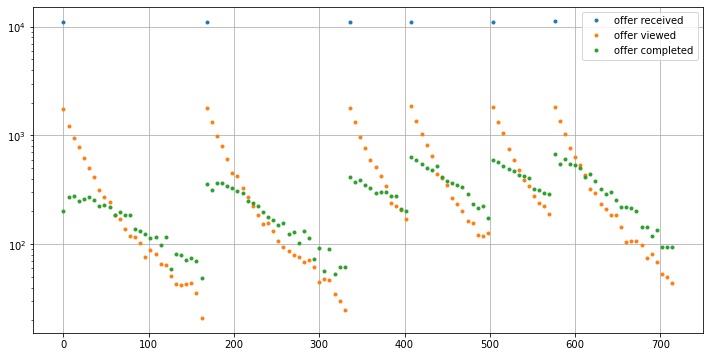

In [73]:
# Check the timeline of offer received, viewed, and completed
events = all_data['event'].unique()
plt.figure(figsize=(12, 6))
for event in events:
    time_df = all_data[all_data.event == event]
    data = time_df.groupby('time')['event'].count()
    plt.semilogy(data, '.', label=event)
    
plt.grid(True)
plt.legend()
plt.show()

## Modeling and Evaluation

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [149]:
# Generate dataset for model

offers = pd.DataFrame(all_data.groupby(['person', 'offer_id'])[['offer received', 'offer viewed', 'offer completed']].sum())
offers = offers.reset_index()
# Generate y label: either viewed=0 or completed=0 means not successful
offers['success'] = (offers['offer viewed'] * offers['offer completed']).astype(bool)

offers = offers.merge(cleaned_profile, left_on='person', right_on='id')
offers.drop(columns=['id'], inplace=True)
offers = offers.merge(cleaned_portfolio, left_on='offer_id', right_on='id')
offers.drop(columns=['id'], inplace=True)

## select predictors
offers = offers[['success', 'offer_id', 'age', 'income', 'memberdays', 'F', 'M', 'O', 'reward', 'difficulty', 'duration',
                'web', 'email', 'mobile', 'social', 'bogo', 'discount', 'informational']]

offer_ids = offers.offer_id.unique().tolist()
mapping = {v: k for k, v in dict(enumerate(offer_ids)).items()}
offers['offer_id2'] = offers.offer_id.map(mapping)
# offer_id = pd.get_dummies(offers['offer_id2'])
# offers = pd.concat([offers, offer_id], axis=1)

print("Label success ratio = {}".format(offers.success.mean()))

Label success ratio = 0.42553692368983376


In [150]:
def evaluate_model_performance(model, X, y):
    """ Prints a model's accuracy and F1-score
    
    INPUT:
        model: Model object
        
        X: Training data matrix

        y: Expected model output vector
    
    OUTPUT:
        accuracy: Model accuracy
        
        f1_score: Model F1-score"""
    

    y_pred = model.predict(X)

    model_accuracy = accuracy_score(y, y_pred)
    model_f1_score = f1_score(y, y_pred)
    
    return model_accuracy, model_f1_score

In [151]:
y = offers['success']
X = offers.drop(['success', 'offer_id'], axis=1)

In [153]:
# Test one classifier

trans = MinMaxScaler()
model = GradientBoostingClassifier()
pipeline = Pipeline(steps=[('transformer', trans), ('model', model)])


# train test dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

# Evaluation
model_accuracy, model_f1_score = evaluate_model_performance(pipeline, X_train, y_train)
print("Training results")
print("Traing model accuracy: %.3f" % (model_accuracy))
print("Traing model f1-score: %.3f" % (model_f1_score))

print("Testing results")
model_accuracy, model_f1_score = evaluate_model_performance(pipeline, X_test, y_test)
    
print("Testing model accuracy: %.3f" % (model_accuracy))
print("Testing model f1-score: %.3f" % (model_f1_score))

Training results
Traing model accuracy: 0.771
Traing model f1-score: 0.731
Testing results
Testing model accuracy: 0.766
Testing model f1-score: 0.724


### Model and evaluation Summary
As shown in the output, both training score and test score are close to each other. There is no over fiting issues here.

### Kfold crossvalidation
We could do k-fold cross valication to further validate the models

In [154]:
# Cross validation
trans = MinMaxScaler()
model = GradientBoostingClassifier()
pipeline = Pipeline(steps=[('transformer', trans), ('model', model)])

# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report pipeline performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


Accuracy: 0.767 (0.004)


## Deployment
The deployment step will be excluded here